<a href="https://colab.research.google.com/github/yiwenwangANU/Tensorflow_Certificate/blob/main/Coursera_Course_Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import layers

In [17]:
def plot_series(x, y, format='-', start=0, end=None,
                title=None, xlabel=None, ylabel=None, legend=None):
  
  plt.figure(figsize=(10, 6))

  if type(y) is tuple:
    for y_curr in y:
      plt.plot(x[start:end], y_curr[start:end], format)
  else:
    plt.plot(x[start:end], y[start:end], format)

  plt.xlabel(xlabel)
  plt.ylabel(ylabel)

  if legend:
    plt.legend(legend)
  plt.title(title)
  plt.grid=True
  plt.show()

In [3]:
path_to_file = tf.keras.utils.get_file('Sunspots.csv',
                                       'https://storage.googleapis.com/tensorflow-1-public/course4/Sunspots.csv')

81920/70827 [==================================] - 0s 0us/step


In [9]:
raw_df = pd.read_csv(path_to_file)
raw_df

,Unnamed: 0,Date,Monthly Mean Total Sunspot Number
0,0,1749-01-31,96.7
1,1,1749-02-28,104.3
2,2,1749-03-31,116.7
3,3,1749-04-30,92.8
4,4,1749-05-31,141.7
...,...,...,...
3230,3230,2018-03-31,2.5
3231,3231,2018-04-30,8.9
3232,3232,2018-05-31,13.2
3233,3233,2018-06-30,15.9


In [11]:
df = raw_df[{'Date', 'Monthly Mean Total Sunspot Number'}]

In [12]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3235 entries, 1749-01-31 to 2018-07-31
Data columns (total 1 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Monthly Mean Total Sunspot Number  3235 non-null   float64
dtypes: float64(1)
memory usage: 50.5 KB


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [13]:
df

,Monthly Mean Total Sunspot Number
Date,
1749-01-31,96.7
1749-02-28,104.3
1749-03-31,116.7
1749-04-30,92.8
1749-05-31,141.7
...,...
2018-03-31,2.5
2018-04-30,8.9
2018-05-31,13.2


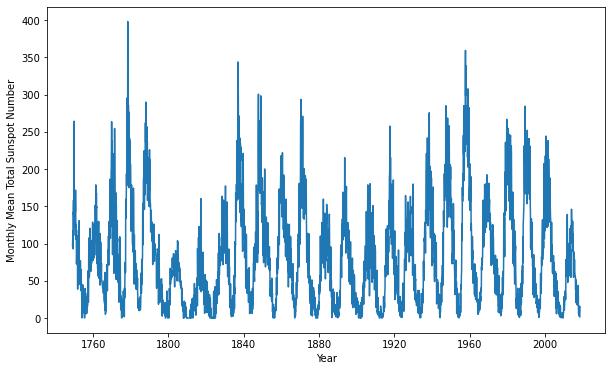

In [18]:
plot_series(df.index,
            df['Monthly Mean Total Sunspot Number'],
            xlabel='Year',
            ylabel='Monthly Mean Total Sunspot Number')

In [53]:
split_time = int(0.8*df.size)

train_df = df.iloc[:split_time, :]
test_df = df.iloc[split_time:, :]

,Monthly Mean Total Sunspot Number
Date,
1964-09-30,7.0
1964-10-31,9.2
1964-11-30,11.1
1964-12-31,22.1
1965-01-31,25.4
...,...
2018-03-31,2.5
2018-04-30,8.9
2018-05-31,13.2


In [23]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
  dataset = dataset.map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.shuffle(buffer_size=shuffle_buffer)
  dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
  return dataset

In [54]:
window_size = 60
batch_size = 32
shuffle_buffer_size = 1000

train_set = windowed_dataset(train_df['Monthly Mean Total Sunspot Number'],
                             window_size,
                             batch_size,
                             shuffle_buffer_size)
test_set = windowed_dataset(test_df['Monthly Mean Total Sunspot Number'],
                             window_size,
                             batch_size,
                             shuffle_buffer_size)

In [55]:
for X, y in train_set.take(1):
  print(X)
  print(y)

tf.Tensor(
[[  0.    0.    0.  ...  89.4  82.6  93.5]
 [ 54.7  34.6   6.3 ...   0.    0.   34. ]
 [145.7 212.  224.7 ... 110.   96.7 106.7]
 ...
 [ 20.5  17.5  66.8 ...  62.7  71.2  74. ]
 [ 41.7  85.5  66.2 ... 100.3  66.5 128.5]
 [ 71.7  71.7  80.5 ...  44.2 113.5  77.2]], shape=(32, 60), dtype=float64)
tf.Tensor(
[ 80.4  36.  105.   79.3  51.7  75.4   0.   58.3  13.3  75.   76.2  14.
  53.2   9.5  44.5  13.3  47.    0.   44.8   6.5 190.   66.2  30.1  64.5
 110.   85.5 103.3  49.2 108.2  49.   56.3 101.5], shape=(32,), dtype=float64)


#Dense Model

In [56]:
tf.keras.backend.clear_session()

In [57]:
model_1 = tf.keras.Sequential([
  tf.keras.Input(shape=window_size,),
  layers.Dense(20, activation='relu'),
  layers.Dense(10, activation='relu'),
  layers.Dense(1)                            
])

model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                1220      
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1,441
Trainable params: 1,441
Non-trainable params: 0
_________________________________________________________________


In [58]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch/20)
)

model_1.compile(loss=tf.keras.losses.Huber(),
                optimizer=tf.keras.optimizers.SGD(1e-8,
                                                  momentum=0.9),
                metrics=['mae'])

history = model_1.fit(train_set,
                      epochs=100,
                      callbacks=[lr_schedule],
                      verbose=0)

(1e-08, 0.001, 0.0, 30.0)

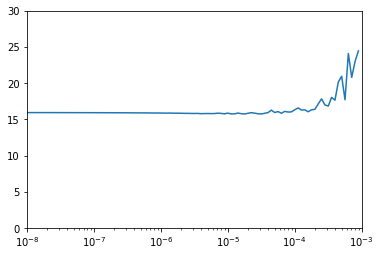

In [103]:
lrs = 1e-8 * (10**(np.arange(100)/20))
plt.semilogx(lrs, history.history['loss'])
plt.axis([1e-8, 1e-3, 0 , 30])

In [ ]:
tf.keras.backend.clear_session()
model_1.compile(loss=tf.keras.losses.Huber(),
                optimizer=tf.keras.optimizers.SGD(1e-4,
                                                  momentum=0.9),
                metrics=['mae'])

history = model_1.fit(train_set,
                      epochs=100,
                      validation_data=test_set)

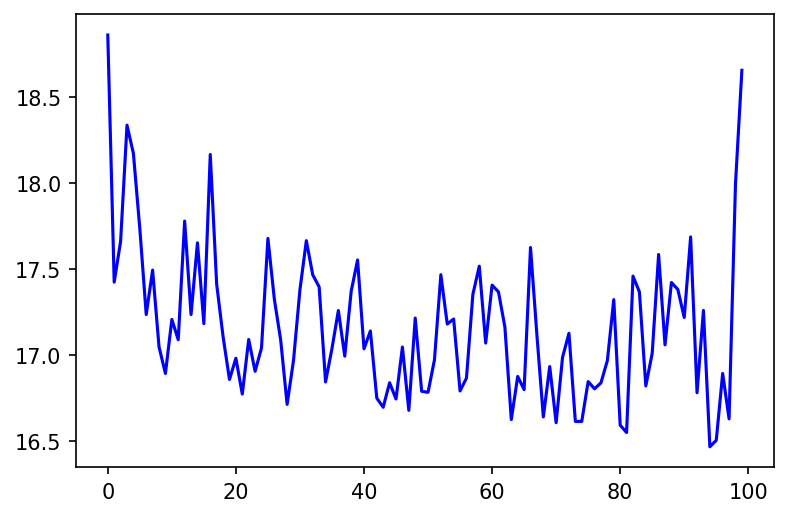

In [61]:
loss = history.history['loss']
epochs = range(len(loss))
plt.figure(dpi = 150)
plt.plot(epochs, loss, 'b', label="training_loss")
plt.show()

In [75]:
def model_forecast(model, series, window_size, batch_size):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda w: w.batch(window_size))
  dataset = dataset.batch(batch_size).prefetch(1)
  forcast = model.predict(dataset)

  return forcast

In [84]:
predictions = model_forecast(model_1,
                             test_df['Monthly Mean Total Sunspot Number'],
                             window_size,
                             batch_size)

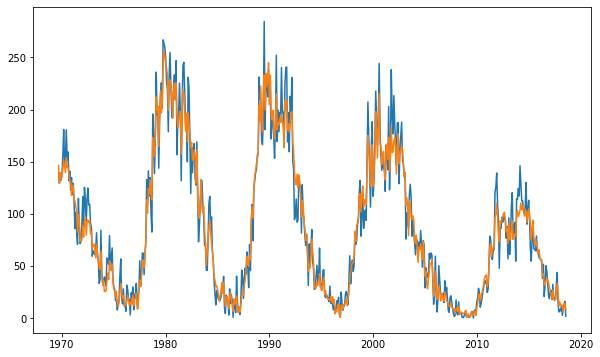

In [90]:
plot_series(test_df.index[window_size-1:],
           (test_df['Monthly Mean Total Sunspot Number'][window_size-1:],
            tf.squeeze(predictions)))

In [92]:
model_1.evaluate(test_set)

19/19 [==============================] - 0s 3ms/step - loss: 15.9086 - mae: 16.3981


[15.908557891845703, 16.398056030273438]

#LSTM Model

In [91]:
tf.keras.backend.clear_session()

In [93]:
window_size = 60
batch_size = 64
shuffle_buffer_size = 1000

train_set = windowed_dataset(train_df['Monthly Mean Total Sunspot Number'],
                             window_size,
                             batch_size,
                             shuffle_buffer_size)
test_set = windowed_dataset(test_df['Monthly Mean Total Sunspot Number'],
                             window_size,
                             batch_size,
                             shuffle_buffer_size)

In [98]:
model_2 = tf.keras.Sequential([
  tf.keras.Input(shape=window_size,),
  layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),  
  layers.Conv1D(filters=32, kernel_size=5, strides=1, padding='causal', activation='relu'),
  layers.LSTM(32, return_sequences=True),
  layers.LSTM(32),
  layers.Dense(30, activation='relu'),
  layers.Dense(10, activation='relu'),
  layers.Dense(1),
  layers.Lambda(lambda x: x * 400)                            
])

model_2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_5 (Lambda)           (None, 1, 60)             0         
                                                                 
 conv1d_3 (Conv1D)           (None, 1, 32)             9632      
                                                                 
 lstm_6 (LSTM)               (None, 1, 32)             8320      
                                                                 
 lstm_7 (LSTM)               (None, 32)                8320      
                                                                 
 dense_9 (Dense)             (None, 30)                990       
                                                                 
 dense_10 (Dense)            (None, 10)                310       
                                                                 
 dense_11 (Dense)            (None, 1)                

In [ ]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch/20)
)

model_2.compile(loss=tf.keras.losses.Huber(),
                optimizer=tf.keras.optimizers.Adam(1e-8),
                metrics=['mae'])

history = model_2.fit(train_set,
                      epochs=100,
                      callbacks=[lr_schedule],
                      verbose=1)

(1e-08, 0.001, 0.0, 60.0)

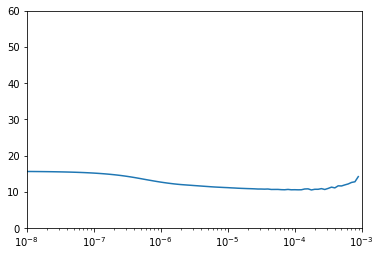

In [120]:
lrs = 1e-8 * (10**(np.arange(100)/20))
plt.semilogx(lrs, history.history['loss'])
plt.axis([1e-8, 1e-3, 0 , 60])

In [ ]:
model_2 = tf.keras.Sequential([
  tf.keras.Input(shape=window_size,),
  layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),  
  layers.Conv1D(filters=32, kernel_size=5, strides=1, padding='causal', activation='relu'),
  layers.LSTM(32, return_sequences=True),
  layers.LSTM(32),
  layers.Dense(30, activation='relu'),
  layers.Dense(10, activation='relu'),
  layers.Dense(1),
  layers.Lambda(lambda x: x * 400)                            
])

model_2.compile(loss=tf.keras.losses.MAE,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae'])

history = model_2.fit(train_set,
                      epochs=200,
                      validation_data=test_set,
                      verbose=1,
                      callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, restore_best_weights=True),
                                         tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=25, verbose=1)])

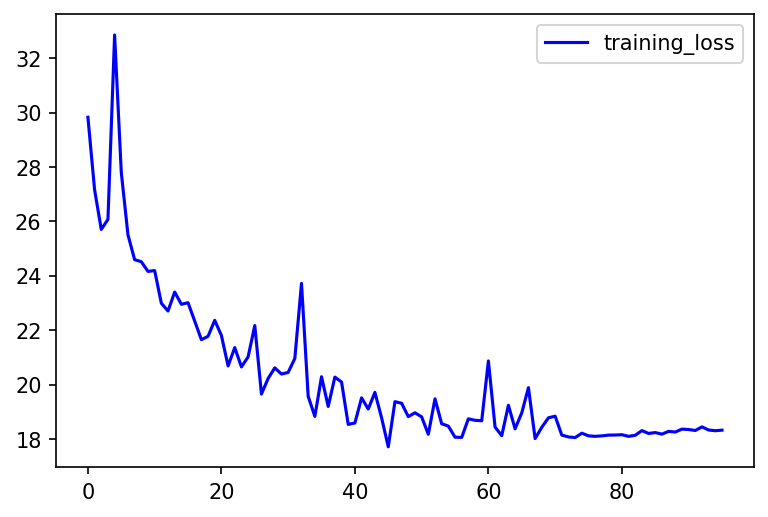

In [125]:
loss = history.history['val_loss']
epochs = range(len(loss))
plt.figure(dpi = 150)
plt.plot(epochs, loss, 'b', label="training_loss")
plt.legend()
plt.show()

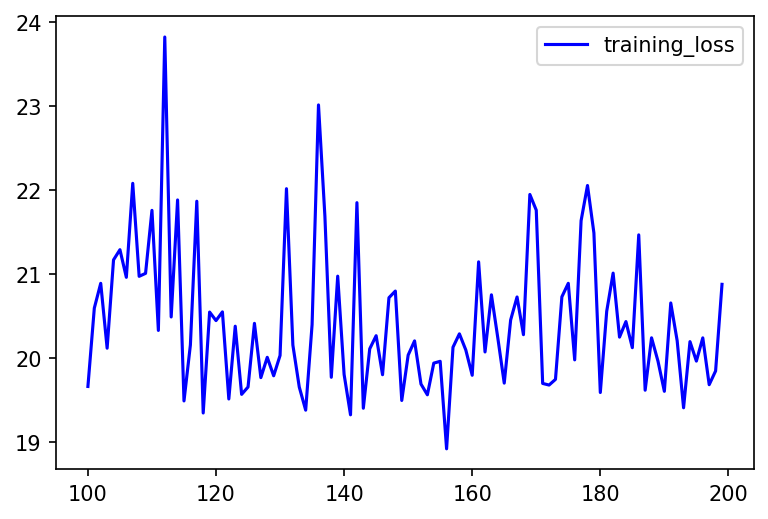

In [118]:
loss = history.history['val_loss']
epochs = range(len(loss))
plt.figure(dpi = 150)
plt.plot(epochs[100:], loss[100:], 'b', label="training_loss")
plt.legend()
plt.show()

In [126]:
predictions = model_forecast(model_2,
                             test_df['Monthly Mean Total Sunspot Number'],
                             window_size,
                             batch_size)

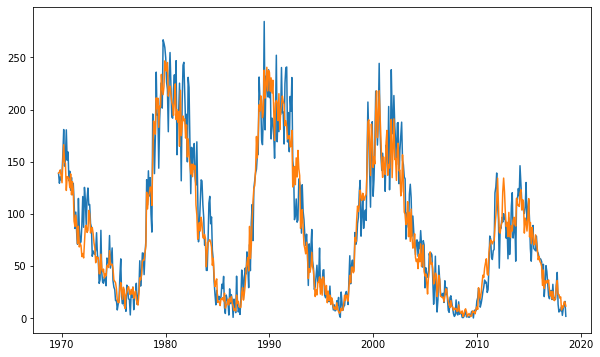

In [127]:
plot_series(test_df.index[window_size-1:],
           (test_df['Monthly Mean Total Sunspot Number'][window_size-1:],
            tf.squeeze(predictions)))

In [128]:
model_2.evaluate(test_set)

10/10 [==============================] - 0s 8ms/step - loss: 17.7180 - mae: 17.7180


[17.71798324584961, 17.71798324584961]